## Projeto Detecção de Fraude de Cartão de Crédito ( PIX?)

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import datetime 

import os
import gc as GarbageCollector

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
import sklearn 
import imblearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, precision_recall_fscore_support, roc_auc_score

##### Reading Data

In [3]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

## merge the datasets

data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [4]:
data.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


##### Fixing Dates

In [5]:
def fix_dates(df):
    
    # create date column
    START_DATE = '2017-12-01' # found this start date from commets 
    
    # required START_DATE since DT is a time delta from start
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    
    df['hour']  = df['TransactionDT'].dt.hour
    df['day']   = df['TransactionDT'].dt.day
    df['dow']   = df['TransactionDT'].dt.dayofweek
    df['month'] = df['TransactionDT'].dt.month
    df['year']  = df['TransactionDT'].dt.year
    
    df.drop(columns=['TransactionDT'], inplace=True)
    
    return df

data = fix_dates(data)

##### Saving Data Required for Submission

In [6]:
# ground truth
truth = data['isFraud']
#data.drop(columns=['isFraud'], inplace=True)

## TransactionIDs for Test
data_trans_id  = pd.DataFrame({'TransactionID': data.index})

In [7]:
# ground truth
#X = data['isFraud']
#data.drop(columns=['isFraud'], inplace=True)

## TransactionIDs for Test
#data_trans_id  = pd.DataFrame({'TransactionID': data.index})

### Preprocessing

##### Removal of columns with too much missing data

In [8]:
# constants
data_columns = data.columns
MISSING_TOL = 0.5

# remove columns that dont matter
one_value_cols      = [col for col in data_columns if data[col].nunique() <= 1]

# remove columns with too many null values
many_null_cols      = [col for col in data_columns if data[col].isnull().sum() / data.shape[0] > MISSING_TOL]

# drop
cols_to_rm = list(set(one_value_cols + many_null_cols))

data.drop(cols_to_rm, axis=1, inplace=True, errors='ignore')


In [9]:
del train_transaction, train_identity
GarbageCollector.collect()

data.shape

(590540, 224)

##### Replace Numerical Missings with Median

In [10]:
# Define List of Cat Features

cards = [f'card{i}' for i in range(1, 7)]
addrs = [f'addr{i}' for i in range(1, 3)]
email = ['P_emaildomain', 'R_emaildomain']
M     = [f'M{i}' for i in range(1, 10)]

identity = ['DeviceType', 'DeviceInfo']
ids = [f'id_{i}' for i in range(12, 39)]

# combine all features
__columns = data.columns.tolist()
cat_features = ['ProductCD'] + cards + addrs + email + M + identity + ids
cat_features_present = [feature for feature in cat_features if feature in __columns]

In [11]:
# Find Medians and Replace

num_features = set(data.columns) - set(cat_features_present) 
num_features = list(num_features)

medians = data[num_features].median()

data.fillna(medians, inplace=True)

In [12]:
# Tag missing Categorical Features and Apply LabelEncoder

from sklearn.preprocessing import LabelEncoder

for c in cat_features_present:
    data[c] = data[c].fillna("missing")

In [13]:
from pandas.api.types import CategoricalDtype
categorical_values = {}

for c in cat_features_present:
    # convert to categorical feature
    data[c] = data[c].astype("category")
    
    # added a unknown to help convert test set categories
    #data[c].cat.add_categories('unknown', inplace=True)
    
    # save all categories defined in test columns
    #categorical_values[c] = data[c].cat.categories
       
# label encoding !
for c in cat_features_present:
    data[c] = data[c].cat.codes

In [14]:
data.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V317,V318,V319,V320,V321,hour,day,dow,month,year
0,2987000,0,68.5,4,10095,500,42,1,38,1,...,117.0,0.0,0.0,0.0,0.0,0,2,5,12,2017
1,2987001,0,29.0,4,1372,303,42,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0,2,5,12,2017
2,2987002,0,59.0,4,2833,389,42,4,58,2,...,0.0,0.0,0.0,0.0,0.0,0,2,5,12,2017
3,2987003,0,50.0,4,13341,466,42,2,14,2,...,1404.0,790.0,0.0,0.0,0.0,0,2,5,12,2017
4,2987004,0,50.0,1,2712,413,42,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0,2,5,12,2017


### Analisando os dados

<AxesSubplot:xlabel='isFraud', ylabel='count'>

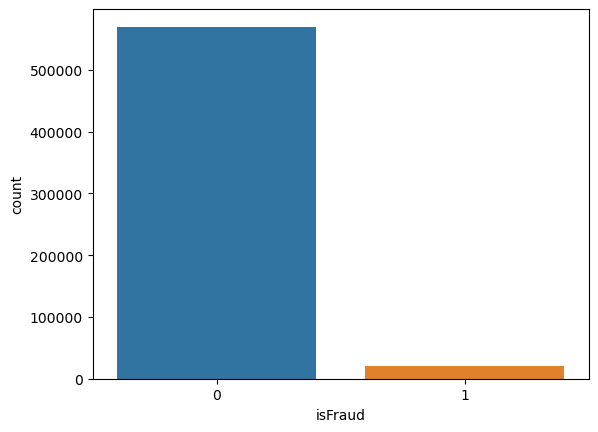

In [15]:
sns.countplot(x='isFraud', data=data)

###  Note que a normalização dos dados é opcional, mas é recomendável para muitos modelos de aprendizagem de máquina. A conversão das colunas de tipo objeto para categórico também é opcional, mas pode ser benéfico para alguns modelos.





In [16]:
# Contagem de grupos
data.groupby(by=['isFraud'])['isFraud'].count()

isFraud
0    569877
1     20663
Name: isFraud, dtype: int64

### É possível notar a diferença da quantidade de uma classe para a outra. Com isso, é necessário o balanceamento das classes para uma análise mais justa

isFraud
0    569877
1     20663
dtype: int64

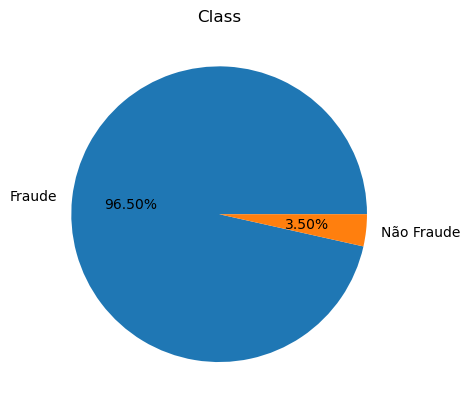

In [17]:
data.value_counts('isFraud').plot.pie(autopct = '%.2f%%', labels = ("Fraude", "Não Fraude"), label = (''), title='Class')
data.value_counts('isFraud')

## Undersampling: consiste em remover aleatoriamente instâncias da classe majoritária para diminuir a sua representatividade no conjunto de dados.

isFraud
1    20663
0    20663
dtype: int64

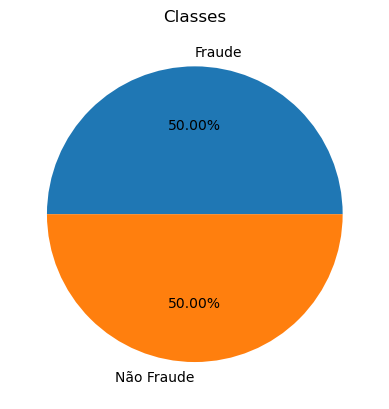

In [18]:
positivo = data[data["isFraud"] == 0]
negativo = data[data["isFraud"] == 1]

# Resampling the original dataset 
positivo_resample = positivo.sample(n = 20663, random_state = 100)
negativo_resample = negativo.sample(n = 20663, random_state = 100)

# Creating new dataset  
df_balanced = pd.concat([positivo_resample, negativo_resample], axis = 0)

df_balanced.value_counts("isFraud").plot.pie(autopct = '%.2f%%', labels = ("Fraude", "Não Fraude"), label = (''), title='Classes')
df_balanced.value_counts("isFraud")

In [19]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41326 entries, 67296 to 193096
Columns: 224 entries, TransactionID to year
dtypes: float64(202), int16(3), int64(7), int8(12)
memory usage: 66.9 MB


In [20]:
# Checagem das colunas
df_balanced.columns[:-1].values

array(['TransactionID', 'isFraud', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'V1', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39',
       'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48',
       'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57',
       'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66',
       'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75',
       'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84',
       'V85

In [21]:
df_balanced.describe()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V317,V318,V319,V320,V321,hour,day,dow,month,year
count,4.132600e+04,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000,...,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000,41326.000000
mean,3.288630e+06,0.500000,142.018231,2.660504,6799.026884,266.916275,48.844166,3.253956,82.435029,1.640783,...,289.139735,163.927467,16.941458,45.864036,28.685957,13.642041,15.460195,3.131564,4.733074,2017.803780
std,1.666793e+05,0.500006,232.299068,1.738799,3779.566453,160.449435,13.874583,1.045831,37.183513,0.493403,...,3366.311371,2011.579882,130.112867,328.370690,205.096094,7.687303,8.908423,1.957576,3.808700,0.397142
min,2.987014e+06,0.000000,0.292000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2017.000000
25%,3.151839e+06,0.000000,39.000000,1.000000,3723.000000,114.000000,42.000000,2.000000,58.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,8.000000,1.000000,2.000000,2018.000000
50%,3.287969e+06,0.500000,72.950000,4.000000,6715.000000,274.000000,42.000000,4.000000,106.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,15.000000,3.000000,3.000000,2018.000000
75%,3.429311e+06,1.000000,150.000000,4.000000,10022.000000,413.000000,42.000000,4.000000,108.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,23.000000,5.000000,5.000000,2018.000000
max,3.577536e+06,1.000000,5191.000000,4.000000,13548.000000,500.000000,114.000000,4.000000,119.000000,4.000000,...,134021.000000,98028.000000,5000.000000,9052.000000,5405.000000,23.000000,31.000000,6.000000,12.000000,2018.000000


In [22]:
df_balanced.shape

(41326, 224)

## Calcular a importância das características: Vamos usar o método de árvore de decisão para calcular a importância das características.

In [23]:
X = df_balanced.drop('isFraud', axis=1)
y = df_balanced['isFraud']

In [24]:
#instanciar o classificador da árvore de decisão
tree_clf = DecisionTreeClassifier(random_state=42)

tree_clf.fit(X, y)

#calculando a importância das características
importances = tree_clf.feature_importances_

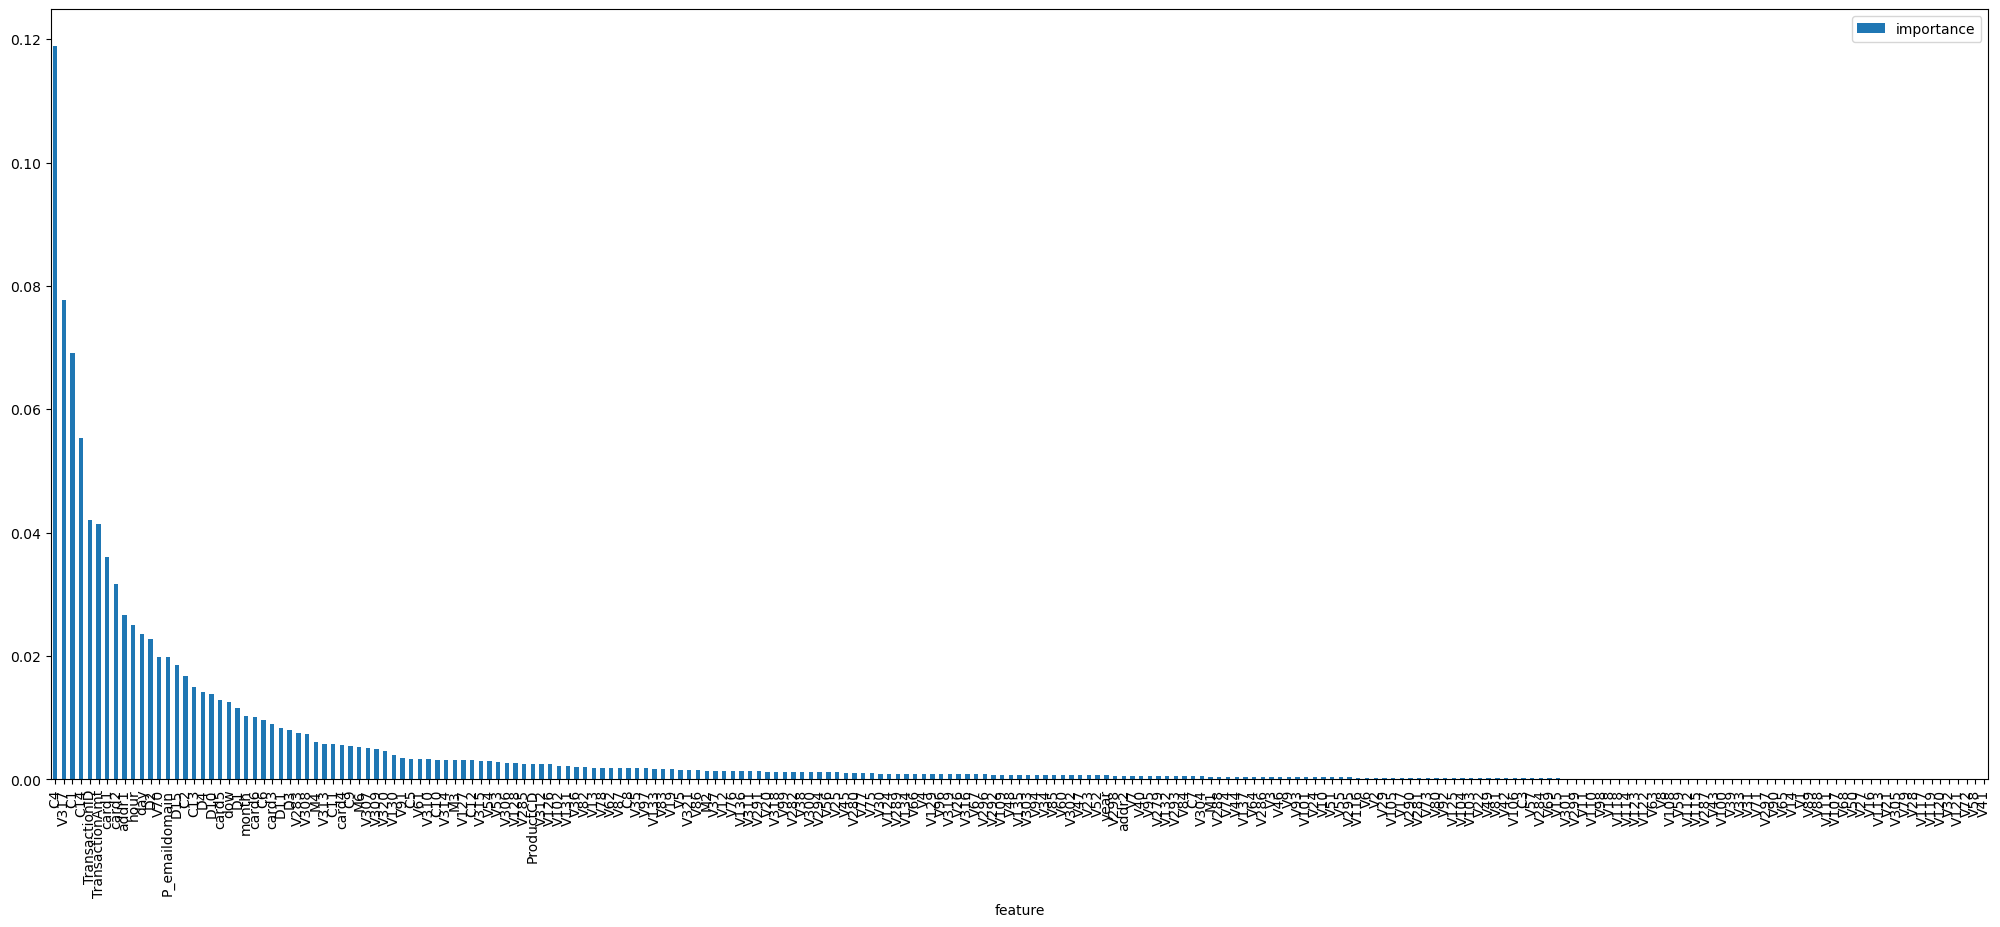

In [25]:
importances_df = pd.DataFrame({'feature': X.columns, 'importance': importances})

importances_df = importances_df.sort_values('importance', ascending=False).set_index('feature')

plt.rcParams['figure.figsize'] = (25, 10)
importances_df.plot.bar();##  Selecionar as características: Vamos selecionar as características com as maiores importâncias.

##  Selecionar as características: Vamos selecionar as características com as maiores importâncias.

In [26]:
#selecionar as características com as maiores importâncias
selected_features = X.columns[importances > 0.01]

#criação de um novo conjunto de dados apenas com as características selecionadas
X_selected = X[selected_features]

In [27]:
X_selected

,TransactionID,TransactionAmt,card1,card2,card5,card6,addr1,P_emaildomain,C1,C2,...,D2,D4,D10,D15,V70,V317,hour,day,dow,month
67296,3054296,59.000,12616,220,108,2,151,54,2.0,1.0,...,97.0,145.0,158.0,142.0,0.0,0.0,17,18,0,12
471515,3458515,29.500,3124,168,106,2,178,16,2.0,2.0,...,7.0,22.0,22.0,22.0,0.0,0.0,21,20,4,4
154755,3141755,29.000,1232,98,87,2,173,31,1.0,1.0,...,97.0,26.0,0.0,0.0,0.0,0.0,23,6,5,1
244941,3231941,49.000,7914,114,108,2,250,31,2.0,1.0,...,97.0,26.0,55.0,0.0,0.0,0.0,13,6,1,2
481909,3468909,280.000,9619,327,58,2,127,54,1.0,1.0,...,97.0,0.0,0.0,0.0,0.0,0.0,22,24,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463460,3450460,50.000,8981,389,108,2,78,16,1.0,1.0,...,97.0,26.0,15.0,52.0,0.0,50.0,22,17,1,4
3907,2990907,49.000,1954,500,108,1,78,31,3.0,3.0,...,28.0,26.0,28.0,52.0,0.0,293.0,20,2,5,12
358709,3345709,300.000,9792,428,54,1,151,16,3.0,3.0,...,97.0,26.0,15.0,52.0,0.0,0.0,21,13,1,3
403975,3390975,29.000,2447,303,2,1,127,54,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23,28,2,3


In [28]:
# Converter o array numpy de volta em um dataframe pandas
X_selected = pd.DataFrame(X_selected, columns=selected_features)

In [29]:
X_selected = X_selected.reset_index(drop=True)

In [30]:
X_selected

,TransactionID,TransactionAmt,card1,card2,card5,card6,addr1,P_emaildomain,C1,C2,...,D2,D4,D10,D15,V70,V317,hour,day,dow,month
0,3054296,59.000,12616,220,108,2,151,54,2.0,1.0,...,97.0,145.0,158.0,142.0,0.0,0.0,17,18,0,12
1,3458515,29.500,3124,168,106,2,178,16,2.0,2.0,...,7.0,22.0,22.0,22.0,0.0,0.0,21,20,4,4
2,3141755,29.000,1232,98,87,2,173,31,1.0,1.0,...,97.0,26.0,0.0,0.0,0.0,0.0,23,6,5,1
3,3231941,49.000,7914,114,108,2,250,31,2.0,1.0,...,97.0,26.0,55.0,0.0,0.0,0.0,13,6,1,2
4,3468909,280.000,9619,327,58,2,127,54,1.0,1.0,...,97.0,0.0,0.0,0.0,0.0,0.0,22,24,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41321,3450460,50.000,8981,389,108,2,78,16,1.0,1.0,...,97.0,26.0,15.0,52.0,0.0,50.0,22,17,1,4
41322,2990907,49.000,1954,500,108,1,78,31,3.0,3.0,...,28.0,26.0,28.0,52.0,0.0,293.0,20,2,5,12
41323,3345709,300.000,9792,428,54,1,151,16,3.0,3.0,...,97.0,26.0,15.0,52.0,0.0,0.0,21,13,1,3
41324,3390975,29.000,2447,303,2,1,127,54,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23,28,2,3


In [31]:
y.shape

(41326,)

In [32]:
# Converter a série y em DataFrame
y_df = pd.DataFrame(y, columns=["isFraud"])

In [33]:
y_df

,isFraud
67296,0
471515,0
154755,0
244941,0
481909,0
...,...
463460,1
3907,1
358709,1
403975,1


In [34]:
y_df = y_df.reset_index(drop=True)

In [35]:
y_df

,isFraud
0,0
1,0
2,0
3,0
4,0
...,...
41321,1
41322,1
41323,1
41324,1


## new data é o novo dataframe com os X(features) importantes selecionados e y ( a classe)

In [36]:
# Concatenar os DataFrames X_selected e y_df
new_data = pd.concat([X_selected, y_df], axis=1)

In [37]:
new_data

,TransactionID,TransactionAmt,card1,card2,card5,card6,addr1,P_emaildomain,C1,C2,...,D4,D10,D15,V70,V317,hour,day,dow,month,isFraud
0,3054296,59.000,12616,220,108,2,151,54,2.0,1.0,...,145.0,158.0,142.0,0.0,0.0,17,18,0,12,0
1,3458515,29.500,3124,168,106,2,178,16,2.0,2.0,...,22.0,22.0,22.0,0.0,0.0,21,20,4,4,0
2,3141755,29.000,1232,98,87,2,173,31,1.0,1.0,...,26.0,0.0,0.0,0.0,0.0,23,6,5,1,0
3,3231941,49.000,7914,114,108,2,250,31,2.0,1.0,...,26.0,55.0,0.0,0.0,0.0,13,6,1,2,0
4,3468909,280.000,9619,327,58,2,127,54,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,22,24,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41321,3450460,50.000,8981,389,108,2,78,16,1.0,1.0,...,26.0,15.0,52.0,0.0,50.0,22,17,1,4,1
41322,2990907,49.000,1954,500,108,1,78,31,3.0,3.0,...,26.0,28.0,52.0,0.0,293.0,20,2,5,12,1
41323,3345709,300.000,9792,428,54,1,151,16,3.0,3.0,...,26.0,15.0,52.0,0.0,0.0,21,13,1,3,1
41324,3390975,29.000,2447,303,2,1,127,54,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,23,28,2,3,1


## Aplicação dos modelos de ML dos trabalhos relacionados de classificação:
#### Seleção de modelos:
* Regressão Logística
* Árvore de Decisão
* KNeighborsClassifier
* SVM (retiramos pelo fato de demorar demais)
* Random Forest.
* XG Boost


#### Divisão dos dados

In [47]:
# Dividir os dados em features e labels
X = new_data.drop("isFraud", axis=1)
y = new_data["isFraud"]

# Dividir os dados em treinamento e teste usando o StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

## PIPELINE REGRESSÃO LOGÍSTICA

In [60]:
import time

start_time = time.time()


pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ('Logistic_Regression', LogisticRegression(max_iter=1000))
])

param_grid = [
    {'Logistic_Regression__solver': ['newton-cg', 'lbfgs', 'sag'],
     'Logistic_Regression__C': [0.1, 1.0, 10.0, 100.0],
     'Logistic_Regression__penalty': ['l1', 'l2']}
]

### O mean_test_score é a média das pontuações de teste obtidas pelo modelo para cada combinação de hiperparâmetros avaliada. Ele é calculado como a média das pontuações de teste em todas as divisões de validação cruzada ou, se o treino é realizado com conjunto de validação único, com o conjunto de validação separado. Esse valor representa uma métrica de desempenho geral do modelo para aquele conjunto de hiperparâmetros.

### Verificarndo os resultados. Você pode acessar os melhores hyperparâmetros e a melhor pontuação usando os atributos `best_params_` , `best_score` (se for a métrica acurracy) e o `best_estimator`

In [61]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

#y_pred = grid.predict(X_train)

print("Melhores parâmetros: ", grid.best_params_)
print("Melhores hiper-parâmetros: ", grid.best_estimator_)
lr_mean_score = grid.best_score_
print("Melhor pontuação de validação cruzada: ", lr_mean_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

results = []
results.append(("Melhores parâmetros: ", grid.best_params_))
results.append(("Melhores hiper-parâmetros: ", grid.best_estimator_))
results.append(("Melhor pontuação de validação cruzada: ", lr_mean_score))

df = pd.DataFrame(results)

#df.to_csv("resultados_grid_search_RL.csv", index=False)

#df.to_html("resultados_grid_search_RL.html")

Melhores parâmetros:  {'Logistic_Regression__C': 100.0, 'Logistic_Regression__penalty': 'l2', 'Logistic_Regression__solver': 'newton-cg'}
Melhores hiper-parâmetros:  Pipeline(steps=[('std_scaler', StandardScaler()),
                ('Logistic_Regression',
                 LogisticRegression(C=100.0, max_iter=1000,
                                    solver='newton-cg'))])
Melhor pontuação de validação cruzada:  0.767664849918803
--- 22 minutes 57 seconds ---


In [62]:
# Using the best parameters from the grid search to fit the logistic regression model
#trocar 
#lr_best = LogisticRegression(random_state=42, C=grid.best_params_['Logistic_Regression__C'], penalty=grid.best_params_['Logistic_Regression__penalty'])
#lr_best.fit(X_train, y_train)

# Predict the test set
#Chamar o refit diretamento do gridSearch
#y_pred_lr = lr_best.predict(X_test)
y_pred_lr = grid.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      5166
           1       0.77      0.75      0.76      5166

    accuracy                           0.77     10332
   macro avg       0.77      0.77      0.77     10332
weighted avg       0.77      0.77      0.77     10332



## PIPELINE ÁRVORE DE DECISÃO

In [63]:
start_time = time.time()

pipe_TREE = Pipeline([
    ('std_scaler', StandardScaler()),
    ('Decision_Tree', DecisionTreeClassifier())
])

param_grid_TREE = [
    {'Decision_Tree__criterion': ['gini', 'entropy'],
     'Decision_Tree__max_depth': [1, 2, 4, 8, 16, 32, None]}
]

In [64]:
grid1 = GridSearchCV(pipe_TREE, param_grid_TREE, cv=5)
grid1.fit(X_train, y_train)

#y_pred = grid1.predict(X_train)

print("Melhores parâmetros: ", grid1.best_params_)
print("Melhores hiper-parâmetros: ", grid1.best_estimator_)
dtc_mean_score = grid.best_score_
print("Melhor pontuação de validação cruzada: ", dtc_mean_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

results1 = []
results1.append(("Melhores parâmetros: ", grid1.best_params_))
results1.append(("Melhores hiper-parâmetros: ", grid1.best_estimator_))
results1.append(("Melhor pontuação de validação cruzada: ", dtc_mean_score))

df1 = pd.DataFrame(results1)

df1.to_csv("S_features_grid_search_TREE.csv", index=False)

df1.to_html("S_features_grid_search_TREE.html")

Melhores parâmetros:  {'Decision_Tree__criterion': 'gini', 'Decision_Tree__max_depth': 16}
Melhores hiper-parâmetros:  Pipeline(steps=[('std_scaler', StandardScaler()),
                ('Decision_Tree', DecisionTreeClassifier(max_depth=16))])
Melhor pontuação de validação cruzada:  0.767664849918803
--- 0 minutes 50 seconds ---


In [65]:
# Using the best parameters from the grid search to fit the decision tree classifier
#dtc_best = DecisionTreeClassifier(random_state=42, criterion=grid1.best_params_['Decision_Tree__criterion'], max_depth=grid1.best_params_['Decision_Tree__max_depth'])
#dtc_best.fit(X_train, y_train)

# Predict the test set
y_pred_dtc = grid1.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_dtc))


              precision    recall  f1-score   support

           0       0.79      0.83      0.81      5166
           1       0.82      0.78      0.80      5166

    accuracy                           0.81     10332
   macro avg       0.81      0.81      0.81     10332
weighted avg       0.81      0.81      0.81     10332



## PIPELINE KNN

In [66]:
start_time = time.time()

pipe_KNN = Pipeline([
    ('std_scaler', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

param_grid_KNN = [
    {'KNN__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
     'KNN__weights': ['uniform', 'distance']}
]

In [67]:
grid2 = GridSearchCV(pipe_KNN, param_grid_KNN, cv=5)
grid2.fit(X_train, y_train)

#y_pred = grid2.predict(X_train)

print("Melhores parâmetros: ", grid2.best_params_)
print("Melhores hiper-parâmetros: ", grid2.best_estimator_)
knn_mean_score = grid.best_score_
print("Melhor pontuação de validação cruzada: ", knn_mean_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

results2 = []
results2.append(("Melhores parâmetros: ", grid2.best_params_))
results2.append(("Melhores hiper-parâmetros: ", grid2.best_estimator_))
results2.append(("Melhor pontuação de validação cruzada: ", knn_mean_score))

df2 = pd.DataFrame(results2)

df2.to_csv("S_features_grid_search_KNN.csv", index=False)

df2.to_html("S_features_grid_search_KNN.html")

Melhores parâmetros:  {'KNN__n_neighbors': 8, 'KNN__weights': 'distance'}
Melhores hiper-parâmetros:  Pipeline(steps=[('std_scaler', StandardScaler()),
                ('KNN',
                 KNeighborsClassifier(n_neighbors=8, weights='distance'))])
Melhor pontuação de validação cruzada:  0.767664849918803
--- 3 minutes 45 seconds ---


In [68]:
# Using the best parameters from the grid search to fit the KNN
#knn_best = KNeighborsClassifier(n_neighbors=grid2.best_params_['KNN__n_neighbors'], weights=grid2.best_params_['KNN__weights'])
#knn_best.fit(X_train, y_train)

# Predict the test set
y_pred_knn = grid2.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      5166
           1       0.81      0.79      0.80      5166

    accuracy                           0.80     10332
   macro avg       0.80      0.80      0.80     10332
weighted avg       0.80      0.80      0.80     10332



## PIPELINE RANDOM FOREST TREE

In [69]:
start_time = time.time()

pipe_RFOREST = Pipeline([
    ('std_scaler', StandardScaler()),
    ('Random_Forest', RandomForestClassifier())
])

param_grid_RFOREST = [
    {'Random_Forest__n_estimators': [10, 50, 100, 200, 500],
     'Random_Forest__criterion': ['gini', 'entropy'],
     'Random_Forest__max_depth': [1, 2, 4, 8, 16, 32, None]}
]

In [70]:
grid3 = GridSearchCV(pipe_RFOREST, param_grid_RFOREST, cv=5)
grid3.fit(X_train, y_train)

#y_pred = grid3.predict(X_train)

print("Melhores parâmetros: ", grid3.best_params_)
print("Melhores hiper-parâmetros: ", grid3.best_estimator_)
rf_mean_score = grid.best_score_
print("Melhor pontuação de validação cruzada: ", rf_mean_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

results3 = []
results3.append(("Melhores parâmetros: ", grid3.best_params_))
results3.append(("Melhores hiper-parâmetros: ", grid3.best_estimator_))
results3.append(("Melhor pontuação de validação cruzada: ", rf_mean_score))

df3 = pd.DataFrame(results3)

df3.to_csv("S_features_grid_search_RFOREST.csv", index=False)

df3.to_html("S_features_grid_search_RFOREST.html")

Melhores parâmetros:  {'Random_Forest__criterion': 'gini', 'Random_Forest__max_depth': 32, 'Random_Forest__n_estimators': 500}
Melhores hiper-parâmetros:  Pipeline(steps=[('std_scaler', StandardScaler()),
                ('Random_Forest',
                 RandomForestClassifier(max_depth=32, n_estimators=500))])
Melhor pontuação de validação cruzada:  0.767664849918803
--- 135 minutes 16 seconds ---


In [71]:
# Using the best parameters from the grid search to fit the RandomForestClassifier
#rf_best = RandomForestClassifier(n_estimators=grid3.best_params_['Random_Forest__n_estimators'], 
#                                  criterion=grid3.best_params_['Random_Forest__criterion'], 
#                                  max_depth=grid3.best_params_['Random_Forest__max_depth'])
#rf_best.fit(X_train, y_train)

# Predict the test set
y_pred_rf = grid3.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5166
           1       0.86      0.84      0.85      5166

    accuracy                           0.85     10332
   macro avg       0.85      0.85      0.85     10332
weighted avg       0.85      0.85      0.85     10332



## PIPELINE XG BOOST

In [72]:
import xgboost as xgb

In [73]:
start_time = time.time()

pipe_XGBOOST = Pipeline([
    ('std_scaler', StandardScaler()),
    ('XGBoost', xgb.XGBClassifier())
])

param_grid_XGBOOST = [
    {'XGBoost__n_estimators': [10, 50, 100, 200, 500],
     'XGBoost__max_depth': [1, 2, 4, 8, 16, 32, None],
     'XGBoost__learning_rate': [0.001, 0.01, 0.1, 1.0]}
]

In [74]:
grid4 = GridSearchCV(pipe_XGBOOST, param_grid_XGBOOST, cv=5)
grid4.fit(X_train, y_train)

#y_pred = grid4.predict(X_train)

print("Melhores parâmetros: ", grid4.best_params_)
print("Melhores hiper-parâmetros: ", grid4.best_estimator_)
xgb_mean_score = grid.best_score_
print("Melhor pontuação de validação cruzada: ", xgb_mean_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

results4 = []
results4.append(("Melhores parâmetros: ", grid4.best_params_))
results4.append(("Melhores hiwwper-parâmetros: ", grid4.best_estimator_))
results4.append(("Melhor pontuação de validação cruzada: ", xgb_mean_score))

df4 = pd.DataFrame(results4)

df4.to_csv("S_features_grid_search_XGBOOST.csv", index=False)

df4.to_html("S_features_grid_search_XGBOOST.html")

[14:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:23:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:25:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:25:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:25:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:25:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:34:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:42:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:44:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:44:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:45:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:46:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[14:51:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:00:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:03:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:03:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:04:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:05:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:08:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:13:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:19:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:20:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:21:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:21:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:21:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:21:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:21:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:23:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:24:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:24:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:27:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[15:30:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [75]:
# Using the best parameters from the grid search to fit the XGBClassifier
#xgb_best = xgb.XGBClassifier(n_estimators=grid4.best_params_['XGBoost__n_estimators'], 
#                                max_depth=grid4.best_params_['XGBoost__max_depth'],
#                             learning_rate=grid4.best_params_['XGBoost__learning_rate'])

#xgb_best.fit(X_train, y_train)

# Predict the test set
y_pred_xgb = grid4.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.88      0.90      0.89      5166
           1       0.90      0.87      0.89      5166

    accuracy                           0.89     10332
   macro avg       0.89      0.89      0.89     10332
weighted avg       0.89      0.89      0.89     10332



## Resultados

In [77]:
from sklearn import metrics

A métrica roc_auc (Receiver Operating Characteristic - Area Under the Curve) é uma medida da capacidade de um modelo de classificação binária de distinguir entre duas classes. Especificamente, a área sob a curva ROC é calculada a partir do gráfico da curva ROC que plota a taxa de verdadeiros positivos (True Positive Rate - TPR) versus a taxa de falsos positivos (False Positive Rate - FPR) para diferentes valores de threshold (ponto de corte) usado para classificar as amostras como positivas ou negativas. A área sob a curva ROC é uma medida da qualidade geral do modelo, sendo que o valor máximo é 1, que indica um modelo perfeito. Um valor de 0,5 indica que o modelo não é melhor do que uma escolha Maleatória. Em geral, quanto maior o valor da métrica, melhor o modelo é considerado em distinguir entre as duas classes.

In [78]:
lr_mean_score # média do score da regressão logística
precision = precision_score(y_train, grid.predict(X_train))
recall = recall_score(y_train, grid.predict(X_train))
f1 = f1_score(y_train, grid.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid.predict(X_train))
accuracy = accuracy_score(y_train, grid.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid.predict(X_train))
classification = metrics.classification_report(y_train, grid.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - REGRESSãO LOGISTICA ==============================')
print()
print ("MEAN SCORE:" "\n", lr_mean_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - REGRESSãO LOGISTICA ==============================

MEAN SCORE:
 0.767664849918803

PRECISãO:
 0.7781515931130022

RECALL:
 0.7611795831451249

F1:
 0.7695720250521922

ACURÁRIA BALANCEADA:
 0.77208491966187

ACURÁCIA:
 0.77208491966187

PRECISãO MACRO:
 0.7722144135441866

RECALL MACRO:
 0.77208491966187

F1 MACRO:
 0.772057811326045

ROC/AUC:
 0.7720849196618701

MATRIZ DE CONFUSÃO:
 [[12134  3363]
 [ 3701 11796]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       0.77      0.78      0.77     15497
           1       0.78      0.76      0.77     15497

    accuracy                           0.77     30994
   macro avg       0.77      0.77      0.77     30994
weighted avg       0.77      0.77      0.77     30994




In [79]:
dtc_mean_score # média do score 
precision = precision_score(y_train, grid1.predict(X_train))
recall = recall_score(y_train, grid1.predict(X_train))
f1 = f1_score(y_train, grid1.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid1.predict(X_train))
accuracy = accuracy_score(y_train, grid1.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid1.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid1.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid1.predict(X_train))
classification = metrics.classification_report(y_train, grid1.predict(X_train))

print()
print('============================== {} - AVALIAÇÃO - ÁRVORE DE DECISÃO ==============================')
print()
print ("MEAN SCORE:" "\n", dtc_mean_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - ÁRVORE DE DECISÃO ==============================

MEAN SCORE:
 0.767664849918803

PRECISãO:
 0.9578035873823105

RECALL:
 0.8993353552300445

F1:
 0.9276490947816827

ACURÁRIA BALANCEADA:
 0.9298573917532426

ACURÁCIA:
 0.9298573917532426

PRECISãO MACRO:
 0.9314651945304182

RECALL MACRO:
 0.9298573917532426

F1 MACRO:
 0.9297919863388688

ROC/AUC:
 0.9298573917532426

MATRIZ DE CONFUSÃO:
 [[14883   614]
 [ 1560 13937]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93     15497
           1       0.96      0.90      0.93     15497

    accuracy                           0.93     30994
   macro avg       0.93      0.93      0.93     30994
weighted avg       0.93      0.93      0.93     30994




In [80]:
knn_mean_score # média do score 
precision = precision_score(y_train, grid2.predict(X_train))
recall = recall_score(y_train, grid2.predict(X_train))
f1 = f1_score(y_train, grid2.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid2.predict(X_train))
accuracy = accuracy_score(y_train, grid2.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid2.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid2.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid2.predict(X_train))
classification = metrics.classification_report(y_train, grid2.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - KNN ==============================')
print()
print ("MEAN SCORE:" "\n", knn_mean_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - KNN ==============================

MEAN SCORE:
 0.767664849918803

PRECISãO:
 1.0

RECALL:
 1.0

F1:
 1.0

ACURÁRIA BALANCEADA:
 1.0

ACURÁCIA:
 1.0

PRECISãO MACRO:
 1.0

RECALL MACRO:
 1.0

F1 MACRO:
 1.0

ROC/AUC:
 1.0

MATRIZ DE CONFUSÃO:
 [[15497     0]
 [    0 15497]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     15497
           1       1.00      1.00      1.00     15497

    accuracy                           1.00     30994
   macro avg       1.00      1.00      1.00     30994
weighted avg       1.00      1.00      1.00     30994




In [81]:
rf_mean_score # média do score 
precision = precision_score(y_train, grid3.predict(X_train))
recall = recall_score(y_train, grid3.predict(X_train))
f1 = f1_score(y_train, grid3.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid3.predict(X_train))
accuracy = accuracy_score(y_train, grid3.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid3.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid3.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid3.predict(X_train))
classification = metrics.classification_report(y_train, grid3.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - RANDOM FOREST TREE ==============================')
print()
print ("MEAN SCORE:" "\n", rf_mean_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - RANDOM FOREST TREE ==============================

MEAN SCORE:
 0.767664849918803

PRECISãO:
 1.0

RECALL:
 0.9870942763115441

F1:
 0.9935052282912255

ACURÁRIA BALANCEADA:
 0.9935471381557721

ACURÁCIA:
 0.9935471381557721

PRECISãO MACRO:
 0.9936293559278844

RECALL MACRO:
 0.9935471381557721

F1 MACRO:
 0.9935468694511203

ROC/AUC:
 0.9935471381557721

MATRIZ DE CONFUSÃO:
 [[15497     0]
 [  200 15297]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     15497
           1       1.00      0.99      0.99     15497

    accuracy                           0.99     30994
   macro avg       0.99      0.99      0.99     30994
weighted avg       0.99      0.99      0.99     30994




In [82]:
xgb_mean_score # média do score 
precision = precision_score(y_train, grid4.predict(X_train))
recall = recall_score(y_train, grid4.predict(X_train))
f1 = f1_score(y_train, grid4.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid4.predict(X_train))
accuracy = accuracy_score(y_train, grid4.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid4.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid4.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid4.predict(X_train))
classification = metrics.classification_report(y_train, grid4.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - XG BOOST ==============================')
print()
print ("MEAN SCORE:" "\n", xgb_mean_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - XG BOOST ==============================

MEAN SCORE:
 0.767664849918803

PRECISãO:
 1.0

RECALL:
 1.0

F1:
 1.0

ACURÁRIA BALANCEADA:
 1.0

ACURÁCIA:
 1.0

PRECISãO MACRO:
 1.0

RECALL MACRO:
 1.0

F1 MACRO:
 1.0

ROC/AUC:
 1.0

MATRIZ DE CONFUSÃO:
 [[15497     0]
 [    0 15497]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     15497
           1       1.00      1.00      1.00     15497

    accuracy                           1.00     30994
   macro avg       1.00      1.00      1.00     30994
weighted avg       1.00      1.00      1.00     30994




# Validação

In [83]:
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_lr)
accuracy = accuracy_score(y_test, y_pred_lr)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_lr)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)
classification = metrics.classification_report(y_test, y_pred_lr)
print()
print('============================== {} - AVALIAÇÃO - REGRESSãO LOGÍSTICA ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - REGRESSãO LOGÍSTICA ==============================

PRECISãO:
 0.7730708035003978

RECALL:
 0.7524196670538134

F1:
 0.7626054541887385

ACURÁRIA BALANCEADA:
 0.7657762291908633

ACURÁCIA:
 0.7657762291908633

PRECISãO MACRO:
 0.7659660201514056

RECALL MACRO:
 0.7657762291908633

F1 MACRO:
 0.7657344367409786

ROC/AUC:
 0.7657762291908632

MATRIZ DE CONFUSÃO:
 [[4025 1141]
 [1279 3887]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77      5166
           1       0.77      0.75      0.76      5166

    accuracy                           0.77     10332
   macro avg       0.77      0.77      0.77     10332
weighted avg       0.77      0.77      0.77     10332




In [84]:
precision = precision_score(y_test, y_pred_dtc)
recall = recall_score(y_test, y_pred_dtc)
f1 = f1_score(y_test, y_pred_dtc)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_dtc)
accuracy = accuracy_score(y_test, y_pred_dtc)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_dtc, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_dtc)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_dtc)
classification = metrics.classification_report(y_test, y_pred_dtc)
print()
print('============================== {} - AVALIAÇÃO - ARVORE DE DECISÃO ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - ARVORE DE DECISÃO ==============================

PRECISãO:
 0.8209349593495935

RECALL:
 0.7818428184281843

F1:
 0.8009121554630181

ACURÁRIA BALANCEADA:
 0.8056523422377081

ACURÁCIA:
 0.8056523422377081

PRECISãO MACRO:
 0.8063470066518847

RECALL MACRO:
 0.8056523422377081

F1 MACRO:
 0.8055421053359711

ROC/AUC:
 0.8056523422377081

MATRIZ DE CONFUSÃO:
 [[4285  881]
 [1127 4039]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      5166
           1       0.82      0.78      0.80      5166

    accuracy                           0.81     10332
   macro avg       0.81      0.81      0.81     10332
weighted avg       0.81      0.81      0.81     10332




In [85]:
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_knn)
accuracy = accuracy_score(y_test, y_pred_knn)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_knn, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_knn)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
classification = metrics.classification_report(y_test, y_pred_knn)
print()
print('============================== {} - AVALIAÇÃO - KNN ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - KNN ==============================

PRECISãO:
 0.8051870916650168

RECALL:
 0.7872628726287263

F1:
 0.796124106880689

ACURÁRIA BALANCEADA:
 0.7983933410762679

ACURÁCIA:
 0.7983933410762679

PRECISãO MACRO:
 0.7985412830034988

RECALL MACRO:
 0.7983933410762679

F1 MACRO:
 0.7983683614713581

ROC/AUC:
 0.7983933410762679

MATRIZ DE CONFUSÃO:
 [[4182  984]
 [1099 4067]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      5166
           1       0.81      0.79      0.80      5166

    accuracy                           0.80     10332
   macro avg       0.80      0.80      0.80     10332
weighted avg       0.80      0.80      0.80     10332




In [86]:
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_rf)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
classification = metrics.classification_report(y_test, y_pred_rf)
print()
print('============================== {} - AVALIAÇÃO - RANDOM FOREST ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - RANDOM FOREST ==============================

PRECISãO:
 0.860928471807133

RECALL:
 0.8364305071622145

F1:
 0.8485027000490919

ACURÁRIA BALANCEADA:
 0.8506581494386372

ACURÁCIA:
 0.8506581494386373

PRECISãO MACRO:
 0.8509423085555521

RECALL MACRO:
 0.8506581494386372

F1 MACRO:
 0.8506279126736538

ROC/AUC:
 0.8506581494386373

MATRIZ DE CONFUSÃO:
 [[4468  698]
 [ 845 4321]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      5166
           1       0.86      0.84      0.85      5166

    accuracy                           0.85     10332
   macro avg       0.85      0.85      0.85     10332
weighted avg       0.85      0.85      0.85     10332




In [87]:
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_xgb)
accuracy = accuracy_score(y_test, y_pred_xgb)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_xgb)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_xgb)
classification = metrics.classification_report(y_test, y_pred_xgb)
print()
print('============================== {} - AVALIAÇÃO - XGB BOOST ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()


============================== {} - AVALIAÇÃO - XGB BOOST ==============================

PRECISãO:
 0.9002991026919243

RECALL:
 0.8739837398373984

F1:
 0.8869462724683235

ACURÁRIA BALANCEADA:
 0.8885985288424313

ACURÁCIA:
 0.8885985288424313

PRECISãO MACRO:
 0.8889308189780856

RECALL MACRO:
 0.8885985288424313

F1 MACRO:
 0.8885747292895848

ROC/AUC:
 0.8885985288424313

MATRIZ DE CONFUSÃO:
 [[4666  500]
 [ 651 4515]]

CLASSIFICAÇÃO:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      5166
           1       0.90      0.87      0.89      5166

    accuracy                           0.89     10332
   macro avg       0.89      0.89      0.89     10332
weighted avg       0.89      0.89      0.89     10332




## Exportando o modelo para a API

In [88]:
#import joblib


# Save the model to a pickle file
#joblib.dump(grid4, "credit_card_xgboost.pkl")

['credit_card_xgboost.pkl']